# Quanatitative Finance with Python

By Daniel Kerim Acatay

In [3]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

# Part 0: Download Economic Time Series

Use <code>pandas_datareader</code> to access the API of financial data providers like Yahhoo! Finance, Google Finance, or the Fred.

In [4]:
# define data to be downloaded
tickers = ['^GSPC', 'MSFT', 'AMZN', 'AAPL', 'WMT', 'PG', 'GM']
provider = 'yahoo'
start = '2010-01-01'

In [5]:
# download data
data = web.DataReader(tickers, provider, start)['Adj Close']
data.to_csv('data/data_raw.csv', sep=';')

In [6]:
# read data from file
data = pd.read_csv('./data/data_raw.csv', sep=';', index_col=0, header=0, parse_dates=True)

In [10]:
# calculate log returns
returns = data / data.shift(1) - 1
returns = returns.fillna(method='ffill').dropna()

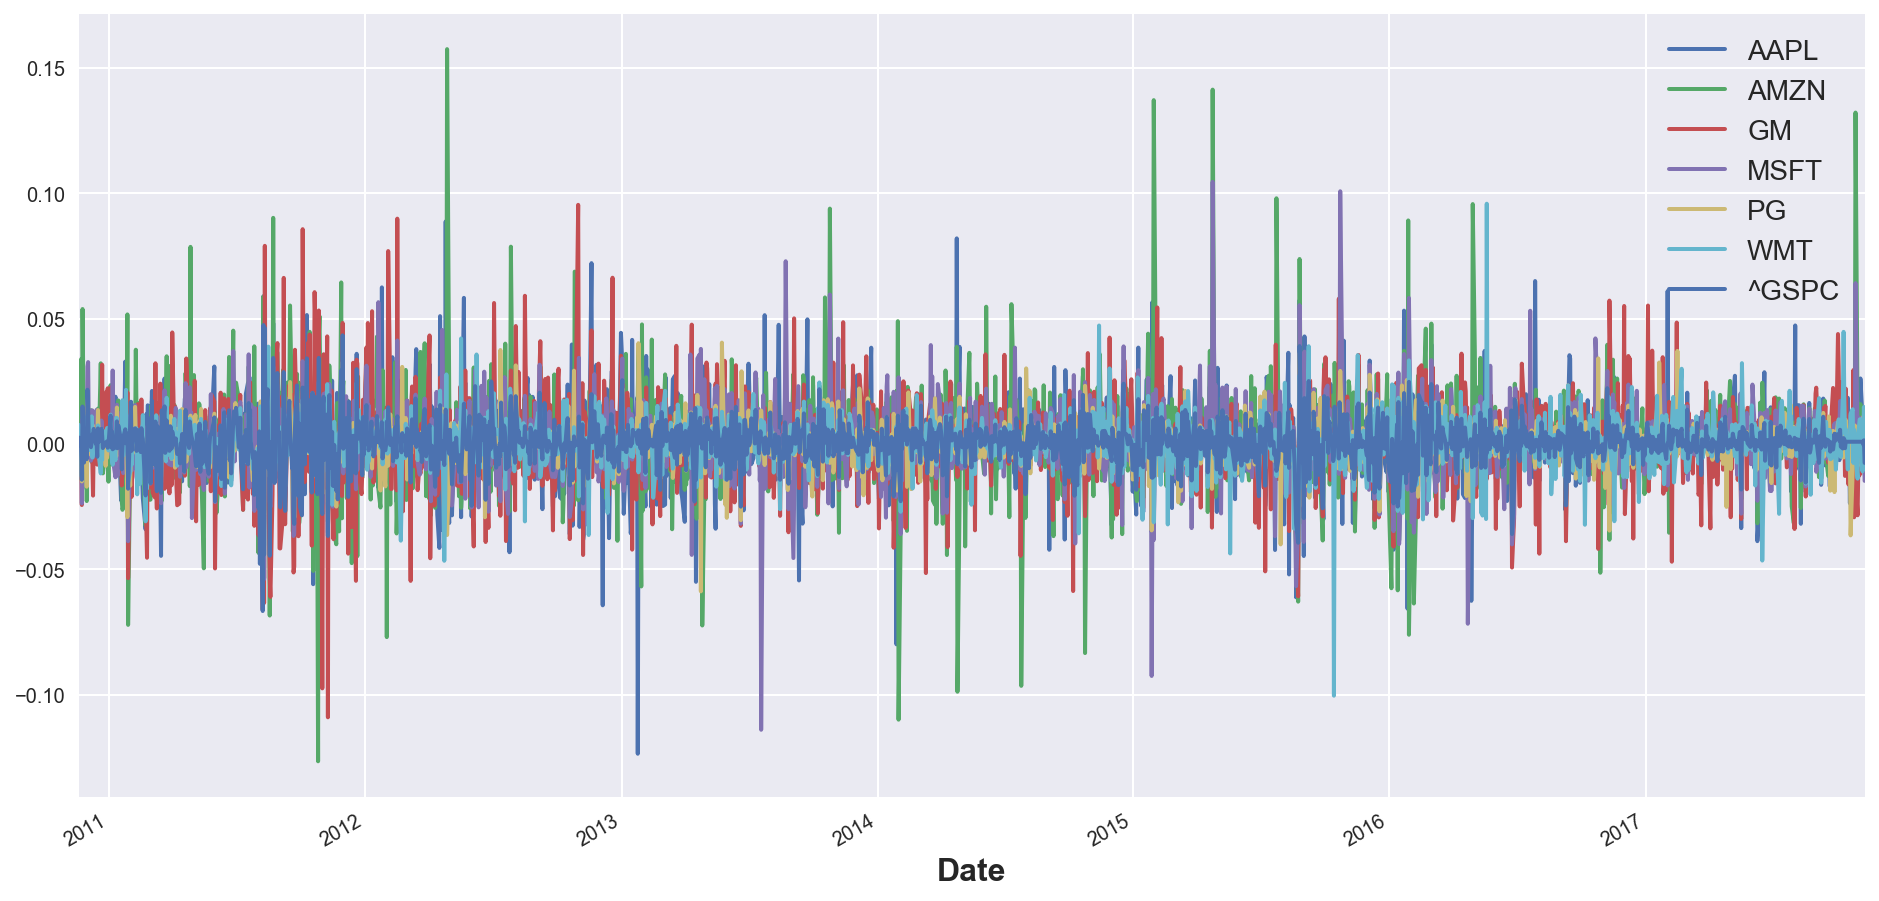

In [11]:
returns.plot()
plt.show()

# Part 1: Modern Portfolio Theory with Python

<a href="https://en.wikipedia.org/wiki/Modern_portfolio_theory">**Modern portfolio theory (MPT)**</a>, or **mean-variance analysis**, introduced by **Harry Markowitz**, is a mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk, defined as variance. Its key insight is that an asset's risk and return should not be assessed by itself, but by how it contributes to a portfolio's overall risk and return.

The MPT assumes that investors are 
* rational
* risk averse.

That is, given two portfolios that offer the same expected return, investors will prefer the less risky one. Thus, an investor will take on increased risk only if compensated by higher expected returns. Conversely, an investor who wants higher expected returns must accept more risk. 

In a perfect market the trade-off will be exactely the same for all investors, but different investors will evaluate the trade-off differently in accordance to their risk appetite. 


## Expected Portfolio Risk and Return

Portfolios consist of multiple assets $i$ with an associated return $r_i$. The expected return on a portfolio is than calculated as the weighted expectation of the return on the individual assets:
$$
E[r_p] = \sum_{i=1}^n w_i \cdot E[r_i]
$$
with
* $r_p$ as the return on the portfolio,
* $r_i$ as the return on asset $i$, and
* $w_i$ as the portfolio weight of asset $i$.

For the remainder we will have a closer look at only two assets, namely the S&P 500 index (^GSPC) and the stock of Amazon (AMZN). The yearly returns are calculated by multiplying the daily log returns $\sqrt{252}$ where 252 is per convention the number of business days in a year.

We will check the portfolio returns for varying portfolio constellation, naturally, this will result in different return potfolio returns.

In [12]:
n_assets = 7

In [13]:
# create random portfolio weights
def create_random_weights(n):
    w = np.random.random(n)
    w /= np.sum(w)
    return w

In [14]:
w = create_random_weights(n_assets)
w

array([ 0.17439,  0.14999,  0.01262,  0.0198 ,  0.2155 ,  0.14098,  0.28673])

The expected value of the portfolio $E[r_p]$ is then simply found by applying the weights to the corresponding asset returns.

In [15]:
# expected portfolio return
pf_return = np.sum(w * log_returns.mean()) * 252
pf_return

0.16561586286456123

In [173]:
def create_random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    exp_returns = np.asmatrix(np.mean(returns))
    w = np.asmatrix(create_random_weights(returns.shape[0]))
    cov_matrix = np.asmatrix(np.cov(returns))
    
    mu = w * exp_returns.T
    sigma = np.sqrt(w * cov_matrix * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return create_random_portfolio(returns)
    return mu, sigma

## Portfolio Variance and Volatility

Calculating the expected return of a portfolio is simple, however, when if we are interested in the comparative performance of a portfolio we need to consider the volatility of the stocks within it. The portfolio variance is calcualted as

$$
\sigma_p^2 = \sum_i w_i^2 \sigma_i^2 + \sum_i \sum_{j \neq i} w_i w_j \sigma_i \sigma_j \rho_{ij}
$$
where
*
*
* $\sigma_i \sigma_j \sigma_{ij} = \rho_{ij}$ is the correlation coefficient
For the case of a portfolio with two assets we can simplify to

$$
\left( w_1 \sigma_1 + w_1 \sigma_1 \right)^2 = w_1^2 \sigma_1^2 + w_2 \sigma_2^2
$$

In [174]:
# calculate correlation coefficient
#rho = np.corrcoef(log_returns['^GSPC'], log_returns['GM'])[1][0]
#rho

In [175]:
#pf_variance = np.dot(w.T, np.dot(log_returns.cov() * 252, w))
#pf_variance

In [176]:
# portfolio volatility
pf_sigma = np.sqrt(np.dot(w.T, np.dot(log_returns.cov() * 252, w)))
pf_sigma

0.16229755263106932

## Efficient Market Frontier

In [177]:
# efficient market Frontier
n_portfolios = 500

mus, stds = np.column_stack([create_random_portfolio(log_returns) for _ in range(n_portfolios)])

ValueError: shapes (1,1755) and (7,1) not aligned: 1755 (dim 1) != 7 (dim 0)

In [149]:
df = pd.DataFrame({'Return': pf_returns, 'Volatility': pf_sigmas})

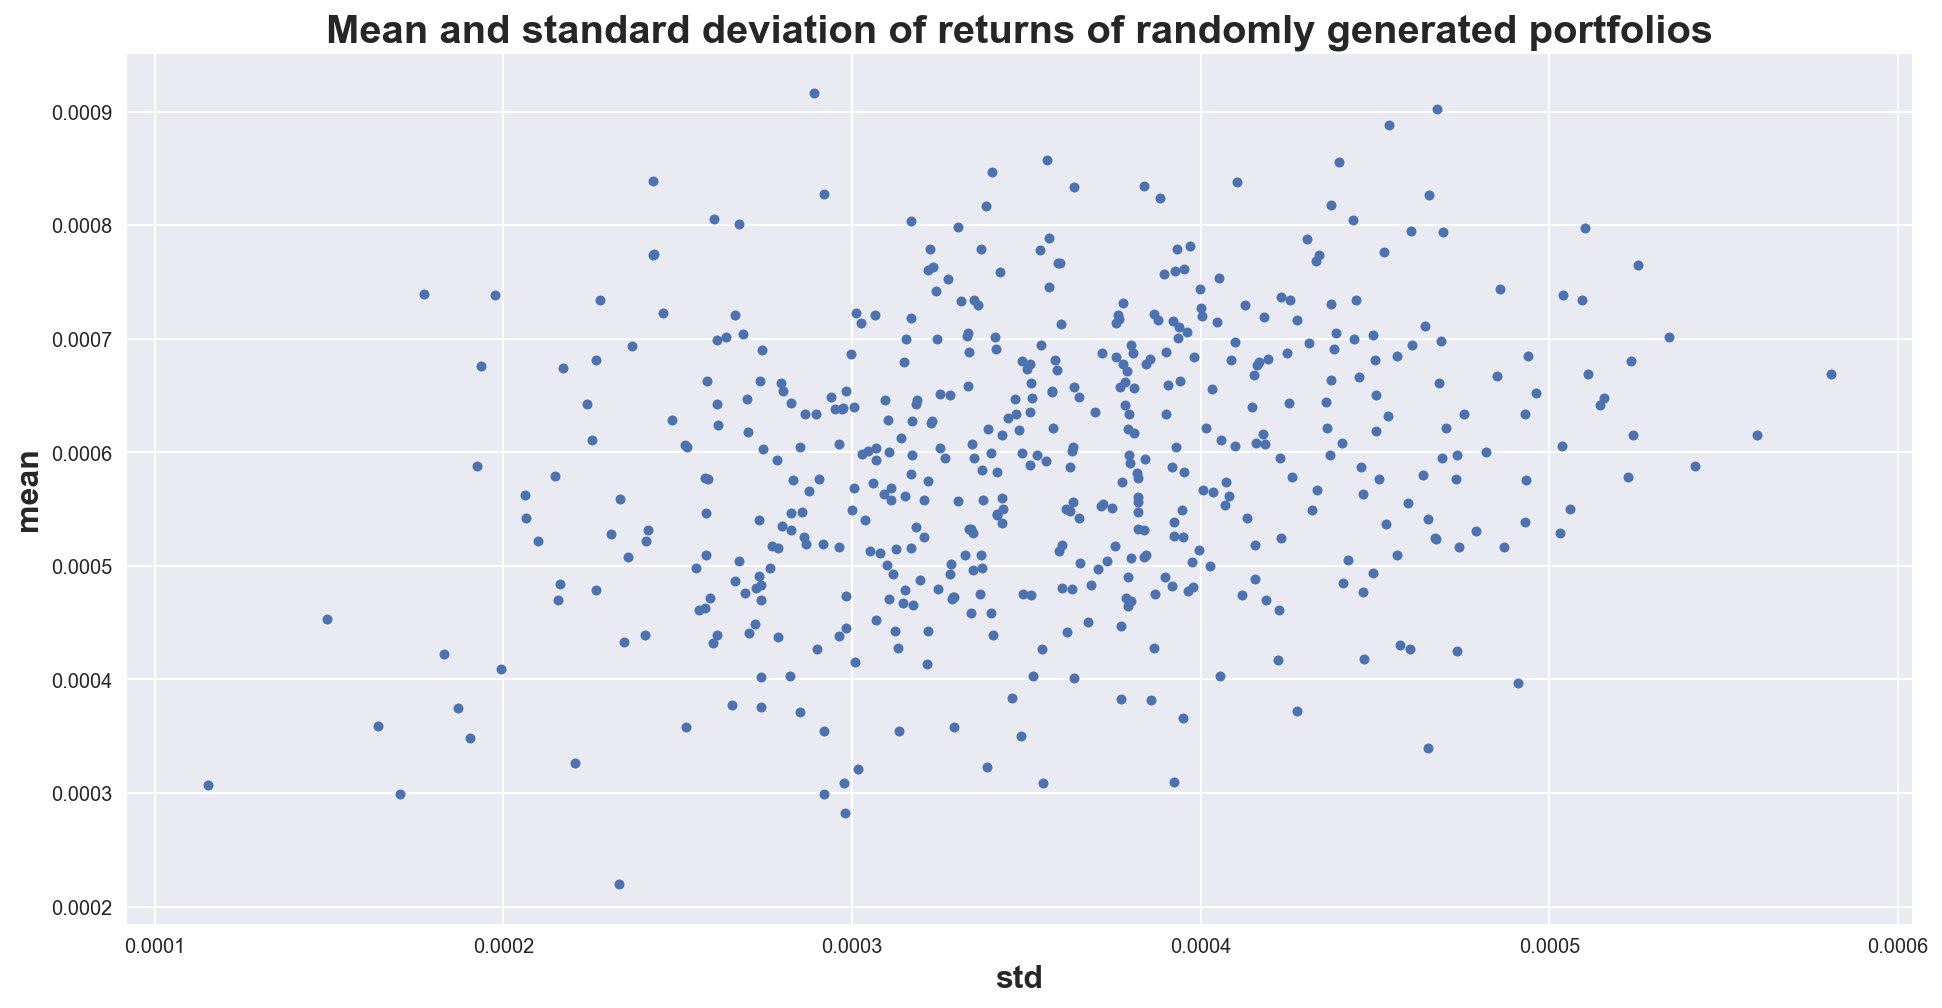

In [167]:
plt.plot(stds, mus, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

http://ahmedas91.github.io/blog/2016/03/01/efficient-frontier-with-python/

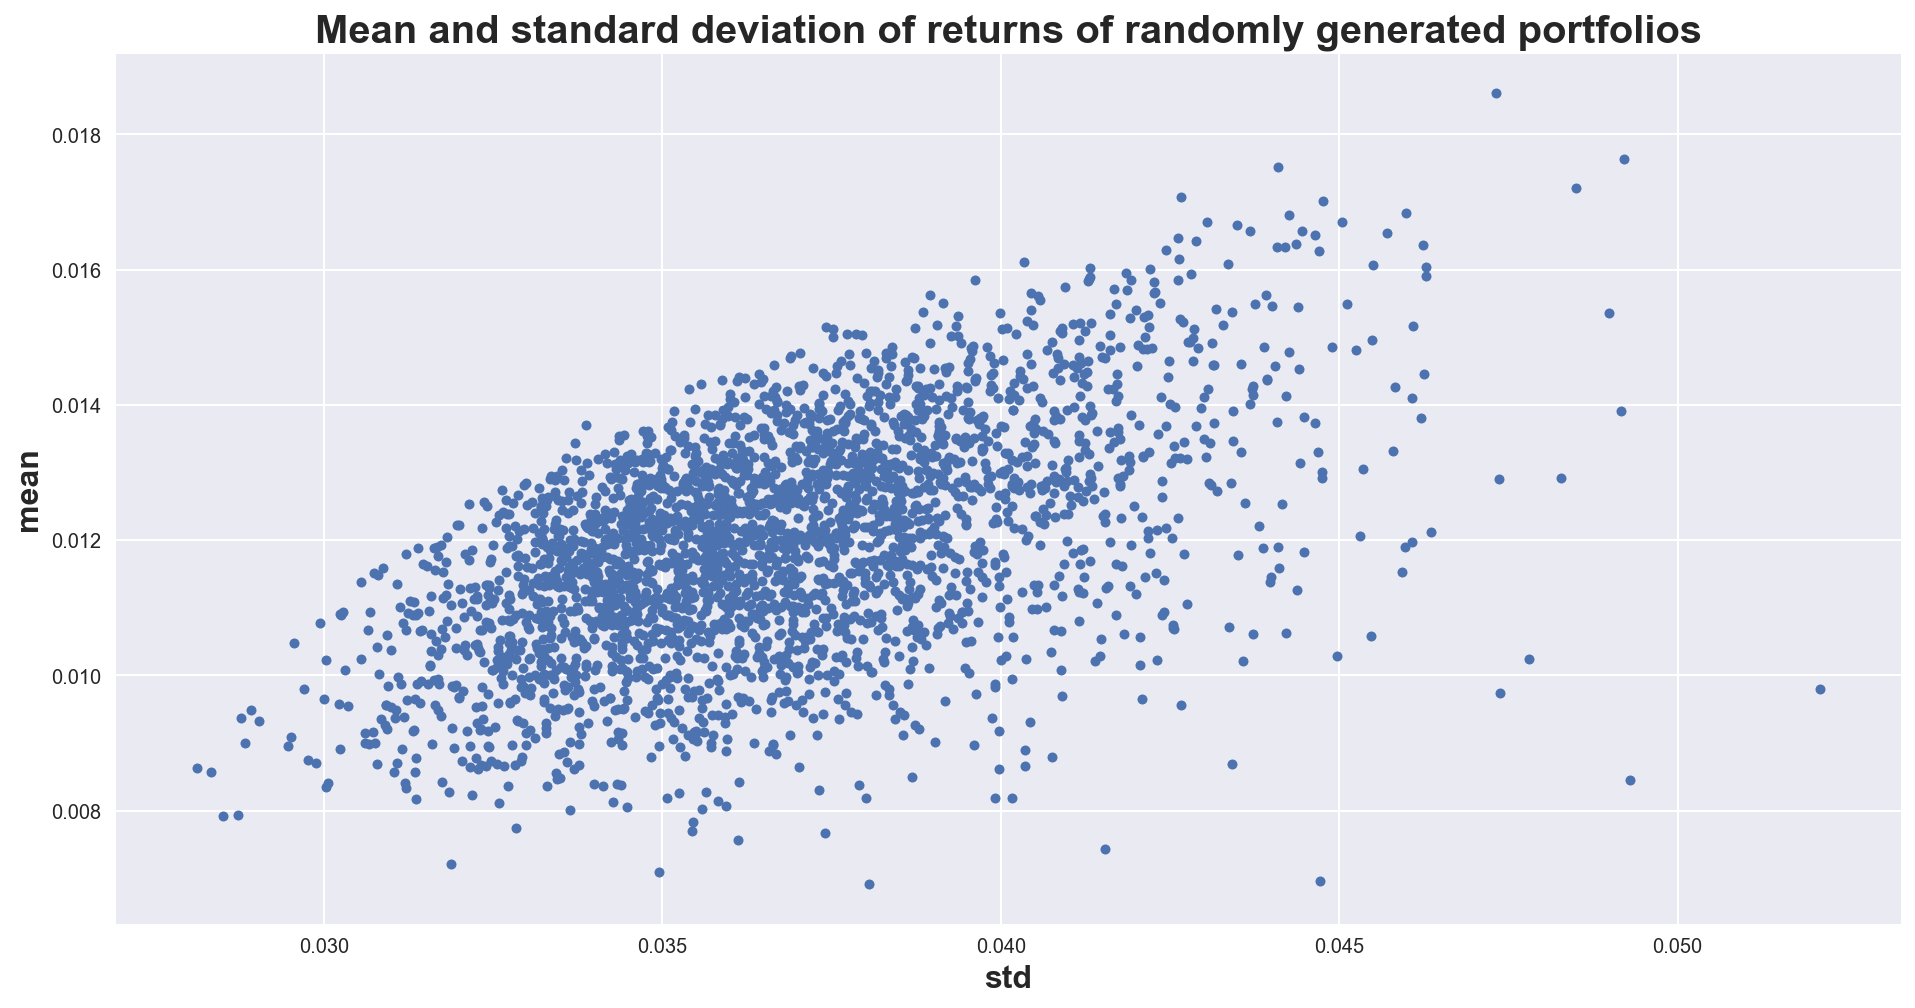

In [16]:
monthly_returns = data.resample('BM', how=lambda x: (x[-1]/x[0])-1)


#Function to get evctor $x$ of random portfolio weighs that sums to 1:
def random_wieghts(n):
    a = np.random.rand(n)
    return a/a.sum()

def initial_portfolio(monthly_returns):
    
    cov_matrix = np.matrix(monthly_returns.cov())
    expected_returns = np.matrix(monthly_returns.mean())
    w = np.matrix(random_wieghts(expected_returns.shape[1]))
    
    mu = w.dot(expected_returns.T)
    sigma = np.sqrt(w * cov_matrix.dot(w.T))
    
    return mu[0,0],sigma[0,0]

n_portfolios = 3000
means, stds = np.column_stack([
    initial_portfolio(monthly_returns) 
    for _ in range(n_portfolios)
])

plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

In [209]:
import cvxopt as opt
from cvxopt import solvers

def frontier(monthly_returns):
    cov = np.matrix(monthly_returns.cov())
    n = monthly_returns.shape[1]
    avg_ret = np.matrix(monthly_returns.mean()).T
    r_min = 0.01
    mus = []
    for i in range(120):
        r_min += 0.0001
        mus.append(r_min)
    P = opt.matrix(cov)
    q = opt.matrix(np.zeros((n, 1)))
    G = opt.matrix(np.concatenate((
                -np.transpose(np.array(avg_ret)), 
                -np.identity(n)), 0))
    A = opt.matrix(1.0, (1,n))
    b = opt.matrix(1.0)
    opt.solvers.options['show_progress'] = False
    portfolio_weights = [solvers.qp(P, q, G,
                                    opt.matrix(np.concatenate((-np.ones((1,1))*yy,
                                                               np.zeros((n,1))), 0)), 
                                    A, b)['x'] for yy in mus]
    portfolio_returns = [(np.matrix(x).T * avg_ret)[0,0] for x in portfolio_weights]
    portfolio_stdvs = [np.sqrt(np.matrix(x).T * cov.T.dot(np.matrix(x)))[0,0] for x in portfolio_weights]
    return portfolio_weights, portfolio_returns, portfolio_stdvs

ImportError: DLL load failed: The specified module could not be found.

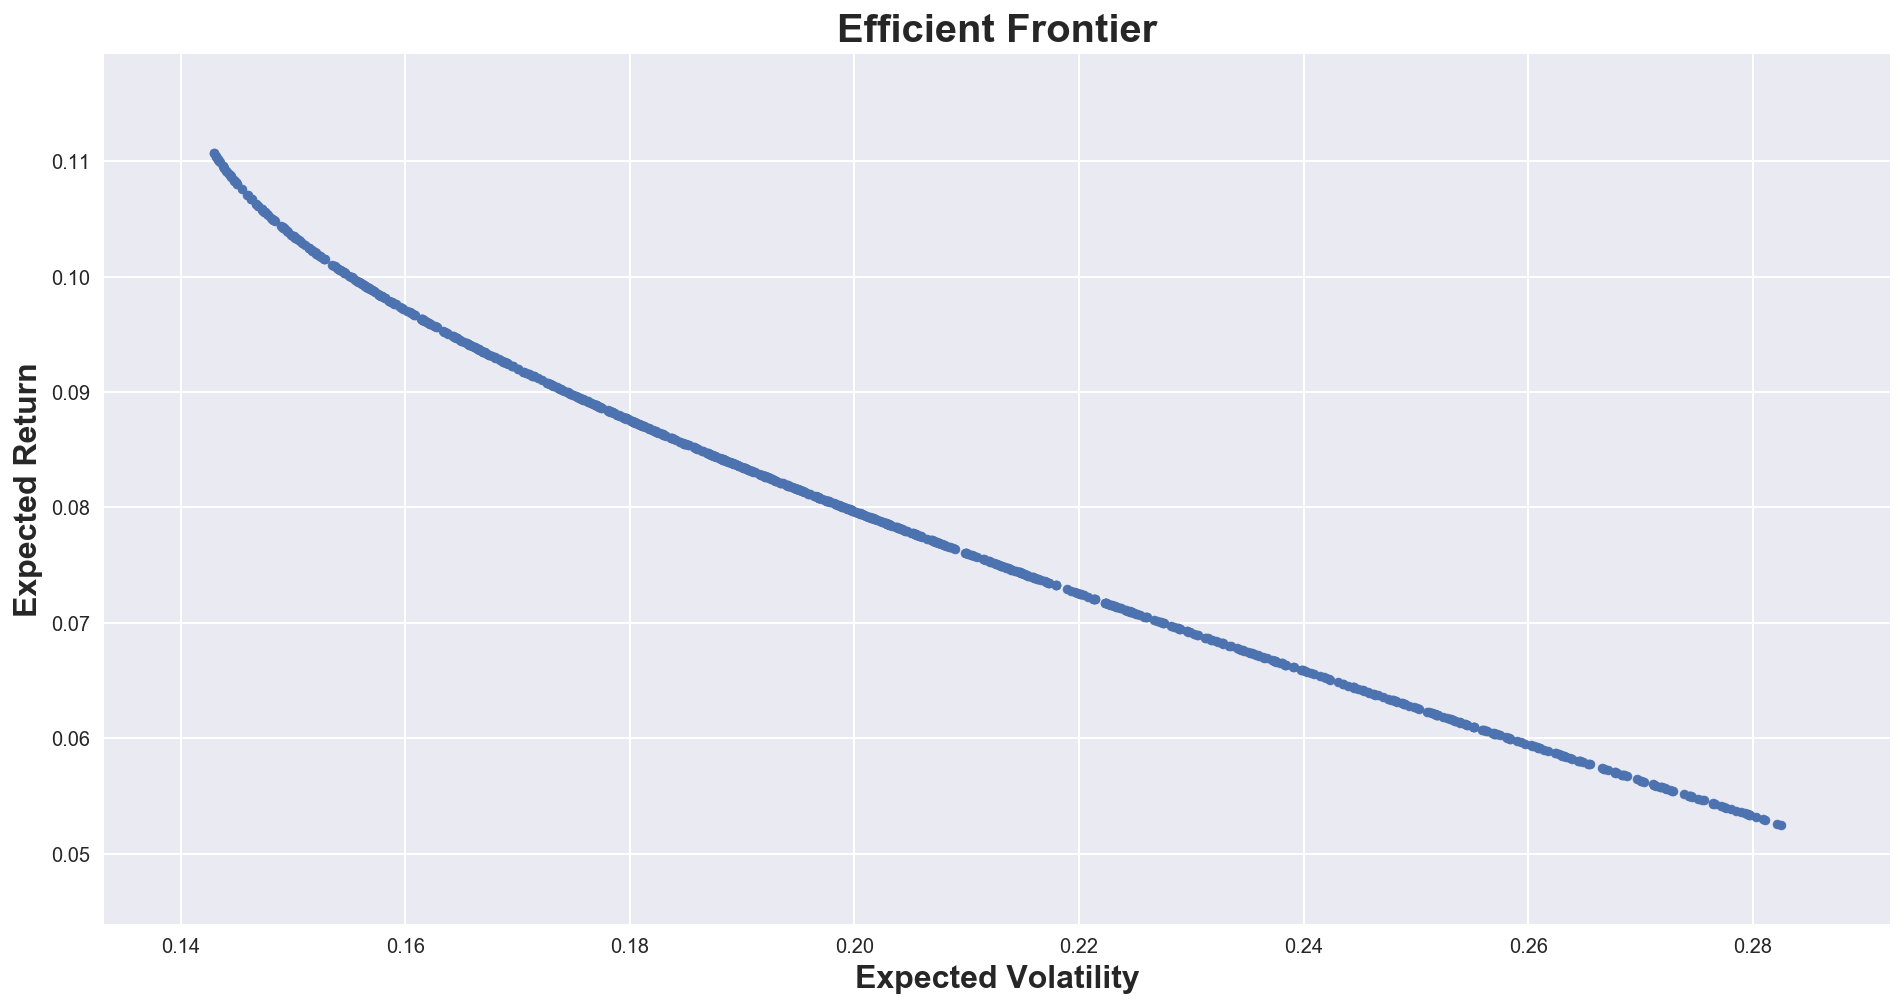

In [150]:
df.plot(x='Volatility', y='Return', kind='scatter')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

# Resources

* https://en.wikipedia.org/wiki/Modern_portfolio_theory
* https://www.codecogs.com/latex/eqneditor.php
